In [84]:
#imports and call stored df
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats


%store -r cb_df_final
%store -r foursquare_df_final
%store -r yelp_df_final

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [102]:
#combine individually with cb then together
cb_foursquare = cb_df_final.merge(foursquare_df_final, how='outer', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])
cb_yelp = cb_df_final.merge(yelp_df_final, how='outer', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])
#combined_df_final = cb_foursquare.merge(yelp_df_final, how='outer', left_on=['latitude', 'longitude', 'name', 'distance'], right_on=['latitude', 'longitude', 'name', 'distance'])
combined_df_final = pd.concat([cb_foursquare, cb_yelp], ignore_index=True)

#drop these columns because not common and will be difficult to replace NaN with appropriate numbers
combined_df_final = combined_df_final.drop(columns=['popularity', 'total_photos', 'total_tips'])


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [93]:
#checking types
combined_df_final.dtypes

latitude         float64
longitude        float64
free_bikes       float64
distance         float64
name              object
price            float64
rating           float64
address           object
total_ratings    float64
dtype: object

In [103]:
#replace NaN values wjere dtype is float with 0
#zero because some of the values may be highly dependent on other variables like total photos may be dependednt upon popularity and location(address)
column_names = ['distance', 'price', 'rating', 'address', 'total_ratings']
for name in column_names:
    combined_df_final[name] = combined_df_final[name].fillna(0)

#drop rows where name is not specified, same with free bikes
combined_df_final = combined_df_final.dropna(subset=['name', 'free_bikes'])
combined_df_final

,latitude,longitude,free_bikes,distance,name,price,rating,address,total_ratings
0,49.262487,-123.114397,8.0,779.000000,The Juice Truck,1.0,9.1,"28 5th Ave W (btwn Manitoba & Ontario), Vancou...",38.0
1,49.274566,-123.121817,6.0,286.000000,The Keg Steakhouse + Bar - Yaletown,3.0,8.2,"1011 Mainland St (at Nelson St), Vancouver BC ...",210.0
2,49.279764,-123.110154,16.0,512.000000,Pourhouse Restaurant,2.0,9.0,"162 Water St (btwn Cambie & Abbott), Vancouver...",380.0
3,49.260599,-123.113504,6.0,618.000000,Rain or Shine,1.0,8.6,"3382 Cambie St (18th Ave), Vancouver BC V5Z 2W5",78.0
4,49.264215,-123.117772,7.0,921.000000,The Juice Truck,1.0,9.1,"28 5th Ave W (btwn Manitoba & Ontario), Vancou...",38.0
...,...,...,...,...,...,...,...,...,...
483,49.247204,-123.101549,2.0,390.279951,Portland Craft,2.0,6.0,"[3835 Main Street, Vancouver, BC V5V 3N9, Canada]",191.0
484,49.285670,-123.112543,10.0,623.441425,Showcase Restaurant & Bar,2.0,8.0,"[1122 West Hastings Street, Vancouver, BC V6E ...",128.0
485,49.250940,-123.101306,3.0,1281.920753,V Yaletown,2.0,7.0,"[1095 Mainland Street, Upper Level, Vancouver,...",6.0
486,49.280977,-123.035969,15.0,392.783241,McDonald's,1.0,4.0,"[3444 East Hastings Street, Vancouver, BC V5K ...",33.0


In [104]:
combined_df_final.describe()

,latitude,longitude,free_bikes,distance,price,rating,total_ratings
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,49.271899,-123.116157,7.773859,703.831747,1.975104,7.732573,183.914938
std,0.011650,0.028764,5.107239,272.907989,0.688034,1.003423,207.589579
min,49.238105,-123.191458,0.000000,16.000000,1.000000,4.000000,1.000000
25%,49.263416,-123.135025,4.000000,500.237461,2.000000,7.000000,47.000000
50%,49.271596,-123.116624,7.000000,716.000000,2.000000,8.000000,120.500000
75%,49.280836,-123.097571,10.000000,912.611123,2.000000,8.500000,249.750000
max,49.302577,-123.035969,29.000000,1386.683256,4.000000,10.000000,1295.000000


<Axes: xlabel='distance'>

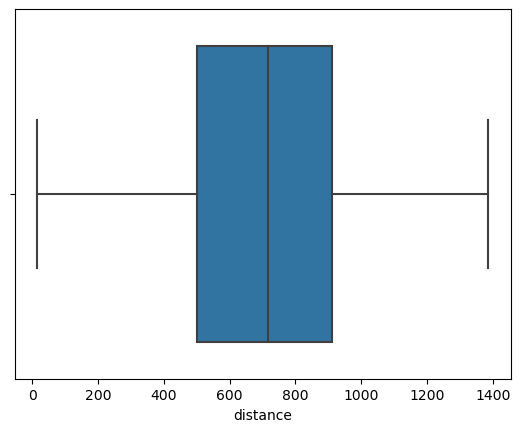

In [105]:
sns.boxplot(x=combined_df_final['distance'])

<Axes: xlabel='price'>

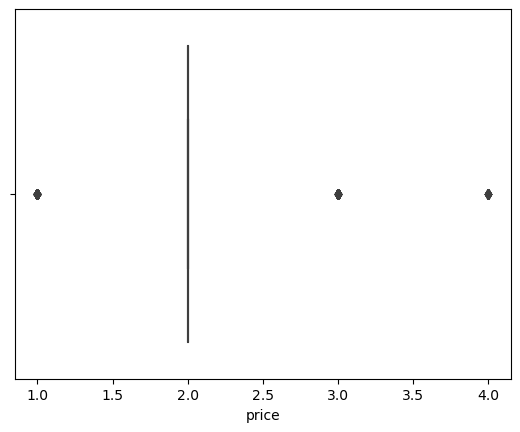

In [106]:
sns.boxplot(x=combined_df_final['price'])

<Axes: xlabel='rating'>

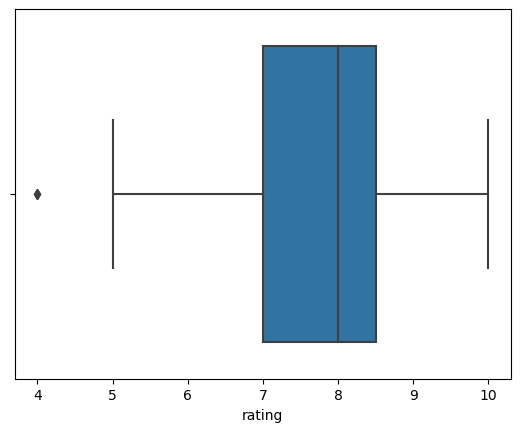

In [107]:
sns.boxplot(x=combined_df_final['rating'])

<Axes: xlabel='total_ratings'>

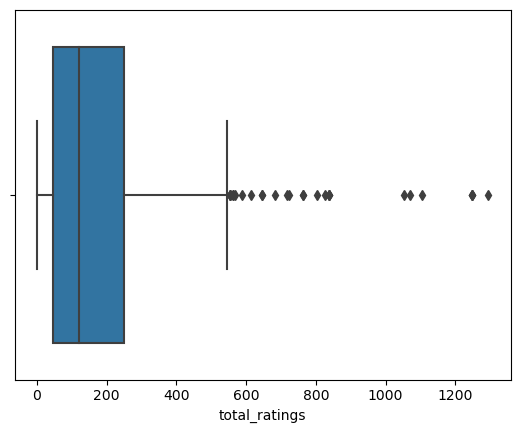

In [108]:
sns.boxplot(x=combined_df_final['total_ratings'])

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Look at the data before and after the join to validate your data.